In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
"""
Purpose: To implement the concepts discussed in the book
"Deep Learning with Pytorch" by eli stevens

github source: https://github.com/deep-learning-with-pytorch/dlwpt-code/tree/master
"""

'\nPurpose: To implement the concepts discussed in the book\n"Deep Learning with Pytorch" by eli stevens\n\ngithub source: https://github.com/deep-learning-with-pytorch/dlwpt-code/tree/master\n'

In [65]:
from os import sys
from pathlib import Path

root_path_colab = '/content/drive/MyDrive/Deep_Learning/torch_tools/'
root_path_relative = "../../"

root_path = root_path_colab
cwd = root_path / Path("Applications/Pytorch_Tutorials/")

module_path = Path(root_path) / Path("torch_tools/")

if module_path.exists():
    path_str = str(module_path.absolute())
    if path_str not in sys.path:
        sys.path.append(path_str)
else:
    raise Exception("Path to package note exists")

In [4]:
# Testing Impoort of torch_tools module
import colab_utils as colu
import tensor_utils as tu

In [13]:
import torch

# Ch. 2

### Part 1: Image recognition

In [5]:
import torchvision.models as models

In [22]:
colu.set_output_cell_size(100)
dir(models)

['AlexNet',
 'AlexNet_Weights',
 'ConvNeXt',
 'ConvNeXt_Base_Weights',
 'ConvNeXt_Large_Weights',
 'ConvNeXt_Small_Weights',
 'ConvNeXt_Tiny_Weights',
 'DenseNet',
 'DenseNet121_Weights',
 'DenseNet161_Weights',
 'DenseNet169_Weights',
 'DenseNet201_Weights',
 'EfficientNet',
 'EfficientNet_B0_Weights',
 'EfficientNet_B1_Weights',
 'EfficientNet_B2_Weights',
 'EfficientNet_B3_Weights',
 'EfficientNet_B4_Weights',
 'EfficientNet_B5_Weights',
 'EfficientNet_B6_Weights',
 'EfficientNet_B7_Weights',
 'EfficientNet_V2_L_Weights',
 'EfficientNet_V2_M_Weights',
 'EfficientNet_V2_S_Weights',
 'GoogLeNet',
 'GoogLeNetOutputs',
 'GoogLeNet_Weights',
 'Inception3',
 'InceptionOutputs',
 'Inception_V3_Weights',
 'MNASNet',
 'MNASNet0_5_Weights',
 'MNASNet0_75_Weights',
 'MNASNet1_0_Weights',
 'MNASNet1_3_Weights',
 'MaxVit',
 'MaxVit_T_Weights',
 'MobileNetV2',
 'MobileNetV3',
 'MobileNet_V2_Weights',
 'MobileNet_V3_Large_Weights',
 'MobileNet_V3_Small_Weights',
 'RegNet',
 'RegNet_X_16GF_Weights'

In [31]:
colu.set_output_cell_size(300)
# -- model ---

# creating different models
alexnet = models.AlexNet()

# the lowercase functions are models
resnet = models.resnet101(pretrained = True)

print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [37]:
# -- data (getting it into tensor)---
# getting unstructured data
from PIL import Image
import requests
from io import BytesIO

example_pic = 'https://static01.nyt.com/images/2019/04/28/world/28london-marathon1/28london-marathon1-superJumbo.jpg'
def image_from_url(
    url=example_pic,
    ):
    response = requests.get(url)
    return Image.open(BytesIO(response.content))

img = image_from_url()

# preparing the preprocessing pipeline (unstructure data to tensor)
from torchvision import transforms
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# preprocesing the image
img_t = preprocess(img)

# reshaping the image so in batch form
batch_t = torch.unsqueeze(img_t, 0)


In [43]:
# --- forward pass for class and confidence
resnet.eval() # for controlling dropout, batchnorm and turning off autograd graph
out = resnet(batch_t)
max_value,max_idx = torch.max(out,1)
class_idx = max_idx.item()

out_softmax = torch.nn.functional.softmax(out,dim=1)[0]*100
confidence = out_softmax[class_idx].item()

print(f"Class = {class_idx}, Confidence = {confidence}")

Class = 862, Confidence = 58.29840850830078


In [50]:
# the top 5 classes
sort_vals,sort_idx = torch.sort(out,dim = -1,descending=True)
sort_idx[0][:5]

tensor([862, 752, 852, 416, 430])

### Part 2: GAN

#### model

In [55]:
# creating the model class

import torch
import torch.nn as nn

class ResNetBlock(nn.Module): # <1>

    def __init__(self, dim):
        super(ResNetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim)

    def build_conv_block(self, dim):
        conv_block = []

        conv_block += [nn.ReflectionPad2d(1)]

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
                       nn.InstanceNorm2d(dim),
                       nn.ReLU(True)]

        conv_block += [nn.ReflectionPad2d(1)]

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
                       nn.InstanceNorm2d(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        out = x + self.conv_block(x) # <2>
        return out


class ResNetGenerator(nn.Module):

    def __init__(self, input_nc=3, output_nc=3, ngf=64, n_blocks=9): # <3>

        assert(n_blocks >= 0)
        super(ResNetGenerator, self).__init__()

        self.input_nc = input_nc
        self.output_nc = output_nc
        self.ngf = ngf

        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=True),
                 nn.InstanceNorm2d(ngf),
                 nn.ReLU(True)]

        n_downsampling = 2
        for i in range(n_downsampling):
            mult = 2**i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3,
                                stride=2, padding=1, bias=True),
                      nn.InstanceNorm2d(ngf * mult * 2),
                      nn.ReLU(True)]

        mult = 2**n_downsampling
        for i in range(n_blocks):
            model += [ResNetBlock(ngf * mult)]

        for i in range(n_downsampling):
            mult = 2**(n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                         kernel_size=3, stride=2,
                                         padding=1, output_padding=1,
                                         bias=True),
                      nn.InstanceNorm2d(int(ngf * mult / 2)),
                      nn.ReLU(True)]

        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        model += [nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, input): # <3>
        return self.model(input)

In [66]:
colu.set_output_cell_size()

# instantiating and loading the model
gan_model = ResNetGenerator()

state_dict_path = cwd / Path("horse2zebra_0.4.0.pth")
state_dict = torch.load(state_dict_path)
gan_model.load_state_dict(state_dict)
gan_model

ResNetGenerator(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): ReLU(inplace=True)
    (10): ResNetBlock(
      (conv_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inplace=True)
        (4): ReflectionPad2d((1, 1, 1, 1))
     

#### data

In [ ]:
from PIL import Image

# loading image
img = Image.open(cwd / Path("./horse.jpg") )
img

In [73]:

# preprocessing
from torchvision import transforms as t
preprocess = t.Compose([
        t.Resize(256),
        t.ToTensor()
])

img_proc = preprocess(img)

# creating batch
batch_img = img_proc.unsqueeze(0)
batch_img.shape

torch.Size([1, 3, 256, 314])

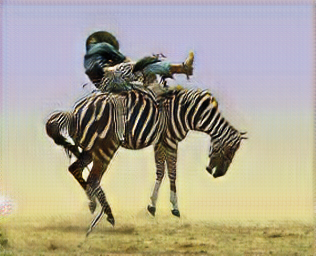

In [74]:
# -- forward pass ---
out = gan_model(batch_img)
out_image = t.ToPILImage()((out.data.squeeze() + 1)/2)
out_image

